This notebook implements example of DCGAN in PyTorch found here: https://github.com/pytorch/examples/tree/master/dcgan

In [0]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Matplotlib magic
%matplotlib notebook

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Set parameters/hyperparameters

# Define an Options Class
class Options:
    def __init__(self):
        self.data = ''  # str: path to dataset
        self.workers = 2  # int: number of data loading workers (try 2)
        self.batchSize = 64  # int: input batch size (try 64)
        self.imageSize = 64  # int: height/width/(depth) of image/voxelgrid
        self.nc = 1  # int: num channels
        self.nz = 100  # int: size of latent z vector (try 100)
        self.ngf = 64  # int: ?? (try 64)
        self.ndf = 64  # int: ?? (try 64)
        self.niter = 25  # int: number of epochs to train for (try 25)
        self.lr = 0.0002  # float: learning rate (try 0.0002)
        self.beta1 = 0.5  # float: beta1 for adam (try 0.5)
        self.cuda = True  # bool: enables cuda (if GPU present)
        self.ngpu = 1  # int: number of GPUs to use (try 1)
        self.netG = ''  # str: path to netG (to continue training)
        self.netD = ''  # str: path to netD (to continue training) 
        self.outf = ''  # str: folder to output images and model checkpoints
        self.manualSeed = None  # int: manual seed
        self.classes = 'bedroom'  # comma separated list of classes for lsun dataset
        self.w_d = 0  # weight of density loss (increase this to get less dense lattices)
        self.w_sp = 0  # surface periodicity loss (increase this to try to make opposing surfaces more periodic)

## MODIFY THIS ##
opt = Options()
opt.data = '/content/drive/My Drive/ADD_YOUR_PATH_TO_THE_NPY_DATASET_FILE_HERE.npy'
opt.niter = 5  # play around with this
opt.outf = '/content/drive/My Drive/ADD_A_PATH_TO_DIRECTORY_TO_STORE_TRAIN_MODELS'
opt.manualSeed = 42  # play around with this
opt.imageSize = 32  # don't change this
opt.w_d = 0  # Increase this to REDUCE density
opt.w_sp = 1e-4  # Increase this to try to make opposing sides more periodic
## END MODIFY ##

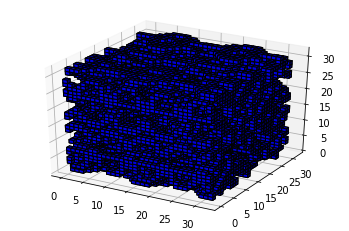

In [0]:
# Plot an existing example (verifies plotting works and that data was loaded successfully)
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
fig = plt.figure()
ax = fig.gca(projection='3d')
training_data = np.load(opt.data)
example_num = 666  # change this to plot another example
example = training_data[example_num]
interior = example > 0.5
exterior = example <= 0.5
ax.voxels(interior, facecolors='b', edgecolor='k')
training_data = None  # free up the memory

Random Seed:  42
Generator(
  (main): Sequential(
    (0): ConvTranspose3d(100, 256, kernel_size=(4, 4, 4), stride=(1, 1, 1), bias=False)
    (1): BatchNorm3d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose3d(256, 128, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
    (4): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose3d(128, 64, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
    (7): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose3d(64, 1, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
    (10): Tanh()
  )
)
Discriminator(
  (main): Sequential(
    (0): Conv3d(1, 64, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2

/pytorch/aten/src/ATen/native/BinaryOps.cpp:81: UserWarning: Integer division of tensors using div or / is deprecated, and in a future release div will perform true division as in Python 3. Use true_divide or floor_divide (// in Python) instead.


[0/5][0/500] Loss_D: 1.5921 Loss_G: 24.3239 D(x): 0.5300 D(G(z)): 0.5687 / 0.0000
[0/5][1/500] Loss_D: 2.2573 Loss_G: 22.5837 D(x): 0.5809 D(G(z)): 0.7716 / 0.0002
[0/5][2/500] Loss_D: 2.9472 Loss_G: 23.3183 D(x): 0.3080 D(G(z)): 0.7659 / 0.0001
[0/5][3/500] Loss_D: 2.1316 Loss_G: 22.0932 D(x): 0.2531 D(G(z)): 0.3872 / 0.0003
[0/5][4/500] Loss_D: 3.8379 Loss_G: 25.7995 D(x): 0.7087 D(G(z)): 0.9644 / 0.0000
[0/5][5/500] Loss_D: 1.8298 Loss_G: 22.3952 D(x): 0.2678 D(G(z)): 0.2199 / 0.0003
[0/5][6/500] Loss_D: 6.8679 Loss_G: 24.1731 D(x): 0.6618 D(G(z)): 0.9980 / 0.0000
[0/5][7/500] Loss_D: 3.9600 Loss_G: 27.9147 D(x): 0.3223 D(G(z)): 0.9056 / 0.0000
[0/5][8/500] Loss_D: 2.1716 Loss_G: 22.4041 D(x): 0.2093 D(G(z)): 0.0296 / 0.0002
[0/5][9/500] Loss_D: 9.7617 Loss_G: 22.5858 D(x): 0.7078 D(G(z)): 0.9999 / 0.0002
[0/5][10/500] Loss_D: 3.0063 Loss_G: 28.5294 D(x): 0.5324 D(G(z)): 0.8804 / 0.0000
[0/5][11/500] Loss_D: 1.3539 Loss_G: 26.0668 D(x): 0.3479 D(G(z)): 0.0007 / 0.0000
[0/5][12/500] 

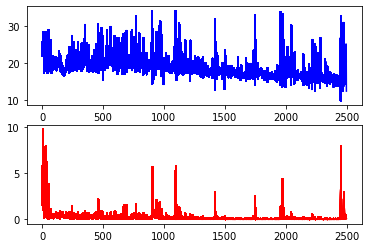

In [0]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils

# Make sure directory exists
assert os.path.exists(opt.outf)
assert os.path.exists(opt.data)

if opt.manualSeed is None:
    opt.manualSeed = random.randint(1, 10000)
print("Random Seed: ", opt.manualSeed)
random.seed(opt.manualSeed)
torch.manual_seed(opt.manualSeed)

cudnn.benchmark = True

if torch.cuda.is_available() and not opt.cuda:
    print("WARNING: You have a CUDA device, so you should probably run with --cuda")

# Load data
# Data is initially a boolgrid where True means interior
# We want interior to be -1 and exterior to be 1 (using convention that interior is negative)
booldata = np.load(opt.data).reshape((-1, opt.nc, opt.imageSize, opt.imageSize, opt.imageSize))
data = np.ones_like(booldata).reshape((-1, opt.nc, opt.imageSize, opt.imageSize, opt.imageSize)).astype(np.float16)
# Force 0's to be -1 to make everything between -1 and 1
data[booldata == True] = -1  # All Trues (interior) become 1
booldata = None  # free memory
dataset = torch.utils.data.TensorDataset(torch.from_numpy(data))
data = None  # free memory
assert dataset
dataloader = torch.utils.data.DataLoader(dataset, batch_size=opt.batchSize,
                                        shuffle=True, num_workers=int(opt.workers))

device = torch.device("cuda:0" if opt.cuda else "cpu")
ngpu = int(opt.ngpu)
nz = int(opt.nz)
ngf = int(opt.ngf)
ndf = int(opt.ndf)
nc = opt.nc

# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0, 1e-2).half()
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1, 1e-2).half()
        m.bias.data.fill_(0).half()

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose3d(nz, ngf * 4, 4, stride=1, padding=0, bias=False),
            nn.BatchNorm3d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 4 x 4 x 4
            nn.ConvTranspose3d(ngf * 4, ngf * 2, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm3d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 8 x 8 x 8
            nn.ConvTranspose3d(ngf * 2,     ngf, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm3d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 16 x 16 x 16
            nn.ConvTranspose3d(    ngf,      nc, 4, stride=2, padding=1, bias=False),
            nn.Tanh()
            # state size. (nc) x 32 x 32 x 32
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output


netG = Generator(ngpu).to(device)
netG.apply(weights_init)
if opt.netG != '':
    netG.load_state_dict(torch.load(opt.netG))
print(netG)


class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 32 x 32 x 32
            nn.Conv3d(nc, ndf, 4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 16 x 16 x 16
            nn.Conv3d(ndf, ndf * 2, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm3d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 8 x 8 x 8
            nn.Conv3d(ndf * 2, ndf * 4, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm3d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 4 x 4 x 4
            nn.Conv3d(ndf * 4, 1, 4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
            # output size. 
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)

        return output.view(-1, 1).squeeze(1)


netD = Discriminator(ngpu).to(device)
netD.apply(weights_init)
if opt.netD != '':
    netD.load_state_dict(torch.load(opt.netD))
print(netD)

# DEFINE OUR CUSTOM LOSS FUNCTION HERE #
class PrintabilityLoss(nn.BCELoss):
    def __init__(self, w_d=0, w_sp=0, weight=None, size_average=None, reduce=None, reduction='mean'):
        self.w_d = w_d
        self.w_sp = w_sp
        super(PrintabilityLoss, self).__init__(weight, size_average, reduce, reduction)
    
    # Try to reduce generated lattice densities
    # voxelgrids is torch.Tensor of shape (batch_size, 1, imageSize, imageSize, imageSize)
    def densityLoss(self, voxelgrids):
        return torch.sum(voxelgrids <= 0) / (voxelgrids.size()[2] * voxelgrids.size()[3] * voxelgrids.size()[4])

    # Try to have periodic faces
    def surfacePeriodicityLoss(self, voxelgrids):
        return torch.sum(torch.nn.functional.softplus(-voxelgrids[:, :, 0, :, :] * voxelgrids[:, :, voxelgrids.size()[2] - 1, :, :])) + \
               torch.sum(torch.nn.functional.softplus(-voxelgrids[:, :, :, 0, :] * voxelgrids[:, :, :, voxelgrids.size()[3] - 1, :])) + \
               torch.sum(torch.nn.functional.softplus(-voxelgrids[:, :, :, :, 0] * voxelgrids[:, :, :, :, voxelgrids.size()[4] - 1]))

    def forward(self, input, target, voxelgrids):
        return super(PrintabilityLoss, self).forward(input, target) + \
            self.w_d * self.densityLoss(voxelgrids) + \
            self.w_sp * self.surfacePeriodicityLoss(voxelgrids) + \
            self.w_cc * self.connectedComponentLoss(voxelgrids)

generatorLoss = PrintabilityLoss(w_d=opt.w_d, w_sp=opt.w_sp)
discriminatorLoss = nn.BCELoss()

fixed_noise = torch.randn(opt.batchSize, nz, 1, 1, 1, device=device)
real_label = 1
fake_label = 0

# setup optimizer
optimizerD = optim.Adam(netD.parameters(), lr=opt.lr, betas=(opt.beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=opt.lr, betas=(opt.beta1, 0.999))

# error values for plotting later
errDvec = list()
errGvec = list()
fig = plt.figure()
axG = fig.add_subplot(211)
axD = fig.add_subplot(212)

for epoch in range(opt.niter):
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # train with real
        netD.zero_grad()
        real_cpu = data[0].float().to(device)
        batch_size = real_cpu.size(0)
        label = torch.full((batch_size,), real_label, device=device)

        output = netD(real_cpu)
        errD_real = discriminatorLoss(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # train with fake
        noise = torch.randn(batch_size, nz, 1, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach())
        errD_fake = discriminatorLoss(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        output = netD(fake)
        errG = generatorLoss(output, label, fake)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        # Print metrics
        print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
            % (epoch, opt.niter, i, len(dataloader),
                errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Plot metrics
        errDvec.append(errD.item())
        errGvec.append(errG.item())
        axD.plot(errDvec, '-r')
        axG.plot(errGvec, '-b')

    # do checkpointing
    torch.save(netG.state_dict(), '%s/netG_epoch_%d.pth' % (opt.outf, epoch))
    torch.save(netD.state_dict(), '%s/netD_epoch_%d.pth' % (opt.outf, epoch))

In [0]:
# Generate some fakes!
num_fakes = 5
noise = torch.randn(num_fakes, nz, 1, 1, 1, device=device)
fakers_gonna_fake = netG(noise).cpu().detach().numpy()

IndexError: ignored

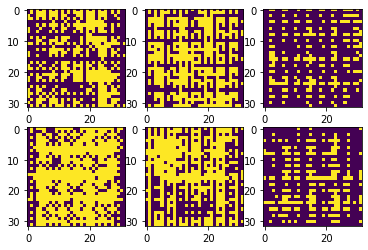

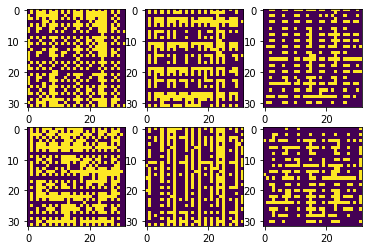

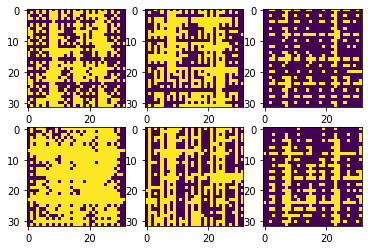

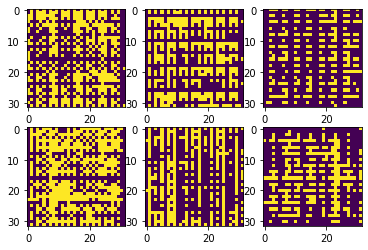

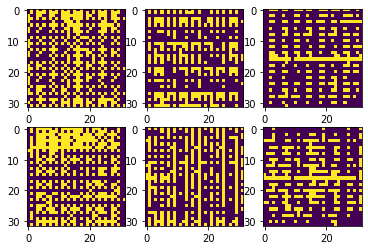

In [0]:
# Visualize faces of selected fakes
import matplotlib as mpl
import matplotlib.pyplot as plt
for example_to_plot in range(num_fakes):
    example = fakers_gonna_fake[example_to_plot].squeeze()
    interior = example <= 0
    fig = plt.figure()
    ax = fig.add_subplot(231)
    ax.imshow(interior[0, :, :])
    ax = fig.add_subplot(234)
    ax.imshow(interior[31, :, :])
    ax = fig.add_subplot(232)
    ax.imshow(interior[:, 0, :])
    ax = fig.add_subplot(235)
    ax.imshow(interior[:, 31, :])
    ax = fig.add_subplot(233)
    ax.imshow(interior[:, :, 0])
    ax = fig.add_subplot(236)
    ax.imshow(interior[:, :, 31])

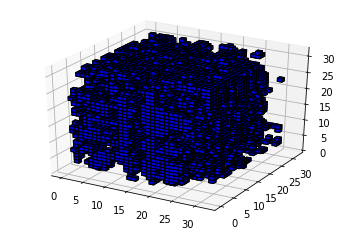

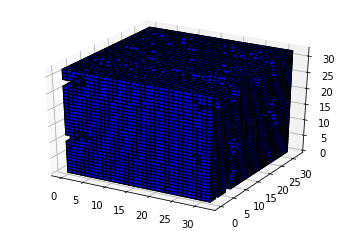

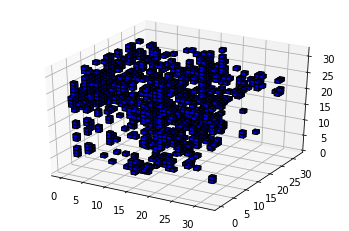

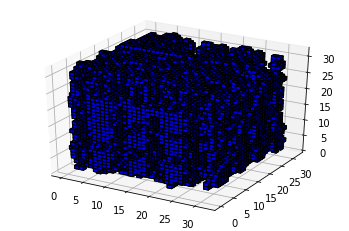

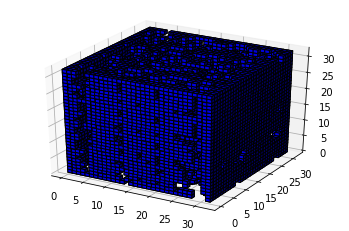

In [0]:
# Visualize selected fakes
import matplotlib as mpl
import matplotlib.pyplot as plt
for example_to_plot in range(num_fakes):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    example = fakers_gonna_fake[example_to_plot].squeeze()
    interior = example <= 0
    # exterior = example > 0
    ax.voxels(interior, facecolors='b', edgecolor='k')


In [0]:
# Do some analytics

# Calculate density of 100 randomly generated lattices
num_fakes = 100
noise = torch.randn(num_fakes, nz, 1, 1, 1, device=device)
fake_news = netG(noise).cpu().detach().numpy()
densities = np.zeros(num_fakes)
for i in range(num_fakes):
    faker = fake_news[i].squeeze()
    densities[i] = np.sum(faker <= 0)/(faker.shape[0]**3)
avg_density = np.mean(densities)
print('Average density:', avg_density)

Average density: 0.33902679443359374
